<a href="https://colab.research.google.com/github/deathperminut/DoctorDegree/blob/main/Paper1/CuadernillosModelos/UNetUnivariado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LIBRERIAS

In [ ]:
import shutil
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error

## CARGAMOS LA BASE DE DATOS

In [ ]:
# Crear la carpeta .kaggle si no existe
os.makedirs("/root/.kaggle", exist_ok=True)
# Mover el archivo kaggle.json a la carpeta
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
# Dar permisos adecuados
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d deathperminut/material-spinners-data

Dataset URL: https://www.kaggle.com/datasets/deathperminut/material-spinners-data
License(s): CC0-1.0
 83% 105M/126M [00:01<00:00, 98.2MB/s] 
100% 126M/126M [00:01<00:00, 104MB/s] 


In [ ]:
# Nombre del archivo descargado (ajústalo según sea necesario)
dataset_zip = "/content/material-spinners-data.zip"
# Extraer los archivos
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")
# Ver archivos extraídos
os.listdir("dataset")

['data.npy.npz', '__notebook__.ipynb']

In [ ]:
#load data
file_ = '/content/dataset/data.npy.npz'
data = np.load(file_)
MS,Nest,L,rd,So,T,Jex,Jex2,Jex3,Jex4,Kan1,KanS,Hex,kd,KDM = data['MS'],data['Nest'],data['L'],data['rd'],data['So'],data['T'],data['Jex'],data['Jex2'],data['Jex3'],data['Jex4'],data['Kan1'],data['KanS'],data['Hex'],data['kd'],data['KDM']

JEX 2

In [ ]:
# Función para definir el encoder-decoder basado en U-Net
def unet_encoder_decoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder: parte de convoluciones y max pooling
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Espacio latente (latent space)
    latent = layers.Flatten()(x)
    latent = layers.Dense(128, activation='relu')(latent)

    # Decoder: capas de upsampling y convoluciones para reconstruir la imagen
    x = layers.Dense(8 * 8 * 256, activation='relu')(latent)
    x = layers.Reshape((8, 8, 256))(x)
    x = layers.UpSampling2D((2, 2))(x)  # Redimensionar a 16x16
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # Redimensionar a 32x32
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # Redimensionar a 64x64
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Cambiar la última capa para que tenga el tamaño de salida correcto (39x39)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Recortar a 39x39 si la imagen es más grande
    decoded = layers.Cropping2D(cropping=((0, 25), (0, 25)))(x)  # Recortar para obtener 39x39

    return models.Model(inputs, decoded, name="encoder_decoder"), latent

# Función para definir el regresor para predecir los 4 parámetros
def regresor(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))

    # Red de regresión para predecir los 4 parámetros
    x = layers.Dense(64, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='linear')(x)  # 4 parámetros continuos

    return models.Model(latent_inputs, outputs, name="regressor")



def combined_loss(y_true, y_pred):
    # Se espera que y_true sea una lista con dos elementos
    y_true_image, y_true_params = y_true[0], y_true[1]  # y_true[0] es la imagen, y_true[1] son los parámetros
    y_pred_image, y_pred_params = y_pred[0], y_pred[1]  # y_pred[0] es la imagen, y_pred[1] son los parámetros

    # Pérdida de reconstrucción para la imagen
    image_loss = tf.reduce_mean(tf.square(y_true_image - y_pred_image))

    # Pérdida para los parámetros (por ejemplo, MSE para los 4 parámetros)
    params_loss = tf.reduce_mean(tf.square(y_true_params - y_pred_params))

    # Combinar ambas pérdidas (ajustando los pesos según sea necesario)
    total_loss = image_loss + params_loss  # Puedes ponerle un peso si quieres balancear las pérdidas

    return total_loss

In [ ]:
# Definir la arquitectura completa
input_shape = (39, 39, 1)  # Imagen de entrada (39x39 con 1 canal)
encoder_decoder, latent_space = unet_encoder_decoder(input_shape)
regressor_model = regresor(latent_space.shape[1])  # Usar el espacio latente del encoder
parameter_predictions = regressor_model(latent_space)

# Reconstrucción de la imagen desde el decoder
reconstructed_image = encoder_decoder(encoder_decoder.input)

# Modelo final que toma la imagen de entrada y predice tanto la imagen como los parámetros
final_model = models.Model(inputs=encoder_decoder.input, outputs=[reconstructed_image, parameter_predictions])
# Compilar el modelo con la pérdida combinada
final_model.compile(optimizer='adam', loss=combined_loss)

# Resumen del modelo
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 39, 39, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 39, 39, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 19, 19, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 19, 19, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 9, 9, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 9, 9, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 4, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 256)      │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 2, 2, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        131,200 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_decoder           │ (None, 39, 39, 1)      │      3,020,161 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regressor (Functional)    │ (None, 1)              │         10,369 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,030,530 (11.56 MB)

 Trainable params: 3,030,530 (11.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_ = MS[:,:,:,:]
Y_ = Jex2.reshape(-1, 1)

In [ ]:
X_.shape,Y_.shape

((54044, 39, 39, 1), (54044, 1))

In [ ]:
# Split the data into training, validation, and testing sets
x_train, x_val, y_train, y_val = train_test_split(X_,Y_, test_size=0.2, random_state=42)

# Normalizamos
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:
import tensorflow as tf

# Habilitar ejecución ansiosa
tf.config.run_functions_eagerly(True)

In [ ]:
# Entrenamos el modelo
final_model.fit(x_train, [x_train, y_train_scaled], epochs=10, batch_size=64, validation_data=(x_val, [x_val, y_val_scaled ]))

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 157s 227ms/step - encoder_decoder_loss: 0.3419 - loss: 0.4980 - regressor_loss: 0.1562 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.3829 - val_regressor_loss: 0.0383
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3250 - loss: 0.3629 - regressor_loss: 0.0379 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.3752 - val_regressor_loss: 0.0306
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3166 - loss: 0.3449 - regressor_loss: 0.0284 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.3738 - val_regressor_loss: 0.0292
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3304 - loss: 0.3599 - regressor_loss: 0.0295 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.3694 - val_regressor_loss: 0.0248
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3165 - loss: 0.3429 - regressor_loss: 0.0264 - val_encoder_decoder_loss: 0.344

338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step


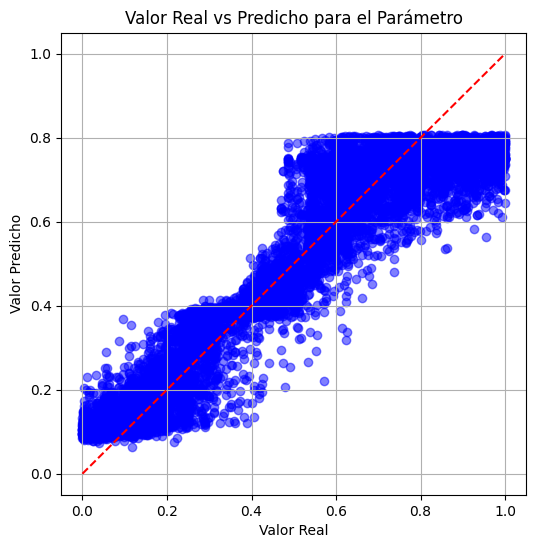

In [ ]:
# Realiza las predicciones usando el modelo
y_pred = final_model.predict(x_val)

# Las predicciones del modelo devuelven dos salidas: imagen y parámetros
# Necesitamos solo los parámetros predichos
y_pred_params = y_pred[1]

# Los valores reales también son los parámetros asociados
y_real_params = y_val_scaled

# Asumiendo que tenemos 4 parámetros, vamos a graficar un gráfico de dispersión para cada uno de ellos
num_params = y_real_params.shape[1]  # Esto debería ser 4 si tienes 4 parámetros

# Graficar para cada uno de los parámetros
plt.figure(figsize=(6, 6))
plt.scatter(y_real_params[:, 0], y_pred_params[:, 0], color='blue', alpha=0.5)
plt.plot([min(y_real_params[:, 0]), max(y_real_params[:, 0])],
         [min(y_real_params[:, 0]), max(y_real_params[:, 0])], color='red', linestyle='--')  # Línea de referencia
plt.title(f"Valor Real vs Predicho para el Parámetro")
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_real_params[:, 0], y_pred_params[:, 0])
mae =  mean_absolute_error(y_real_params[:, 0],y_pred_params[:, 0])
rmse =  mean_squared_error(y_real_params[:, 0],y_pred_params[:, 0])

print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.009029180942268341
mae:  0.07221776431670125
rmse:  0.009029180942268341


calculamos mape y r2

In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_real_params[:, 0],y_pred_params[:, 0])
print(f"R²: {r2:.4f}")

R²: 0.8770


In [ ]:
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_real_params[:, 0], y_pred_params[:, 0])
print(f"MAPE: {mape:.2f}%")


MAPE: 90.03%


los valores son cercanos a cero provemos con SMAPE

In [ ]:
import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Datos reales y predichos (ejemplo)
y_true = np.array([100, 200, 300, 0, 500])  # Incluye un 0 para probar SMAPE
y_pred = np.array([110, 190, 290, 10, 490])

# Calcular SMAPE
smape_value = smape(y_real_params[:, 0], y_pred_params[:, 0])
print(f"SMAPE: {smape_value:.2f}%")


SMAPE: 24.36%


Guardamos los pesos del modelo

In [ ]:
final_model.save_weights("modelo_unet_regresor_Jex2.weights.h5")

## T

In [ ]:
X_ = MS[:,:,:,:]
Y_ = T.reshape(-1, 1)

In [ ]:
# Definir la arquitectura completa
input_shape = (39, 39, 1)  # Imagen de entrada (39x39 con 1 canal)
encoder_decoder, latent_space = unet_encoder_decoder(input_shape)
regressor_model = regresor(latent_space.shape[1])  # Usar el espacio latente del encoder
parameter_predictions = regressor_model(latent_space)

# Reconstrucción de la imagen desde el decoder
reconstructed_image = encoder_decoder(encoder_decoder.input)

# Modelo final que toma la imagen de entrada y predice tanto la imagen como los parámetros
final_model = models.Model(inputs=encoder_decoder.input, outputs=[reconstructed_image, parameter_predictions])
# Compilar el modelo con la pérdida combinada
final_model.compile(optimizer='adam', loss=combined_loss)

In [ ]:
# Split the data into training, validation, and testing sets
x_train, x_val, y_train, y_val = train_test_split(X_,Y_, test_size=0.2, random_state=42)

# Normalizamos
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:
# Entrenamos el modelo
final_model.fit(x_train, [x_train, y_train_scaled], epochs=10, batch_size=64, validation_data=(x_val, [x_val, y_val_scaled ]))

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 153s 226ms/step - encoder_decoder_loss: 0.3276 - loss: 0.4153 - regressor_loss: 0.0877 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.4393 - val_regressor_loss: 0.0947
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3356 - loss: 0.4098 - regressor_loss: 0.0742 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.4361 - val_regressor_loss: 0.0915
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3282 - loss: 0.3906 - regressor_loss: 0.0624 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.4349 - val_regressor_loss: 0.0904
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 224ms/step - encoder_decoder_loss: 0.3379 - loss: 0.4156 - regressor_loss: 0.0777 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.4366 - val_regressor_loss: 0.0920
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 151s 224ms/step - encoder_decoder_loss: 0.3311 - loss: 0.4019 - regressor_loss: 0.0708 - val_encoder_decoder_loss: 0.344

338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step


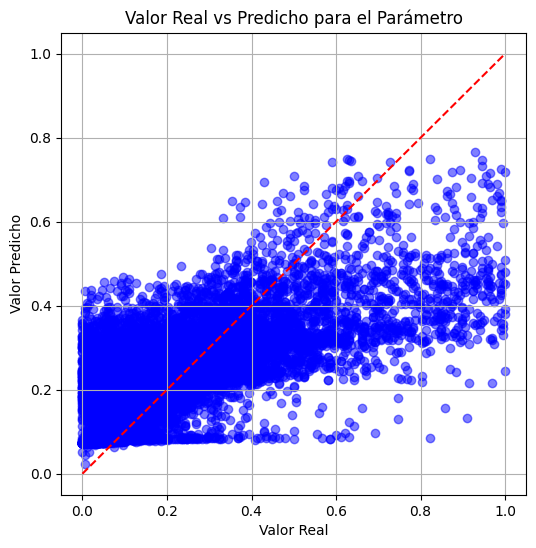

In [ ]:
# Realiza las predicciones usando el modelo
y_pred = final_model.predict(x_val)

# Las predicciones del modelo devuelven dos salidas: imagen y parámetros
# Necesitamos solo los parámetros predichos
y_pred_params = y_pred[1]

# Los valores reales también son los parámetros asociados
y_real_params = y_val_scaled

# Asumiendo que tenemos 4 parámetros, vamos a graficar un gráfico de dispersión para cada uno de ellos
num_params = y_real_params.shape[1]  # Esto debería ser 4 si tienes 4 parámetros

# Graficar para cada uno de los parámetros
plt.figure(figsize=(6, 6))
plt.scatter(y_real_params[:, 0], y_pred_params[:, 0], color='blue', alpha=0.5)
plt.plot([min(y_real_params[:, 0]), max(y_real_params[:, 0])],
         [min(y_real_params[:, 0]), max(y_real_params[:, 0])], color='red', linestyle='--')  # Línea de referencia
plt.title(f"Valor Real vs Predicho para el Parámetro")
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_real_params[:, 0], y_pred_params[:, 0])
mae =  mean_absolute_error(y_real_params[:, 0],y_pred_params[:, 0])
rmse =  mean_squared_error(y_real_params[:, 0],y_pred_params[:, 0])

print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.017104016464124322
mae:  0.09090819447605239
rmse:  0.017104016464124322


In [ ]:
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_real_params[:, 0], y_pred_params[:, 0])
print(f"MAPE: {mape:.2f}%")


MAPE: 175.23%


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_real_params[:, 0],y_pred_params[:, 0])
print(f"R²: {r2:.4f}")

R²: 0.4134


In [ ]:
import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Datos reales y predichos (ejemplo)
y_true = np.array([100, 200, 300, 0, 500])  # Incluye un 0 para probar SMAPE
y_pred = np.array([110, 190, 290, 10, 490])

# Calcular SMAPE
smape_value = smape(y_real_params[:, 0], y_pred_params[:, 0])
print(f"SMAPE: {smape_value:.2f}%")

SMAPE: 56.51%


# JEX 3

In [ ]:
X_ = MS[:,:,:,:]
Y_ = Jex3.reshape(-1, 1)

In [ ]:
# Split the data into training, validation, and testing sets
x_train, x_val, y_train, y_val = train_test_split(X_,Y_, test_size=0.2, random_state=42)

# Normalizamos
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:
# Definir la arquitectura completa
input_shape = (39, 39, 1)  # Imagen de entrada (39x39 con 1 canal)
encoder_decoder, latent_space = unet_encoder_decoder(input_shape)
regressor_model = regresor(latent_space.shape[1])  # Usar el espacio latente del encoder
parameter_predictions = regressor_model(latent_space)

# Reconstrucción de la imagen desde el decoder
reconstructed_image = encoder_decoder(encoder_decoder.input)

# Modelo final que toma la imagen de entrada y predice tanto la imagen como los parámetros
final_model = models.Model(inputs=encoder_decoder.input, outputs=[reconstructed_image, parameter_predictions])
# Compilar el modelo con la pérdida combinada
final_model.compile(optimizer='adam', loss=combined_loss)

In [ ]:
# Entrenamos el modelo
final_model.fit(x_train, [x_train, y_train_scaled], epochs=10, batch_size=64, validation_data=(x_val, [x_val, y_val_scaled ]))

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3510 - loss: 0.5620 - regressor_loss: 0.2110 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.5116 - val_regressor_loss: 0.1670
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3134 - loss: 0.4847 - regressor_loss: 0.1713 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.5099 - val_regressor_loss: 0.1653
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3205 - loss: 0.4904 - regressor_loss: 0.1699 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.5086 - val_regressor_loss: 0.1640
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 152s 225ms/step - encoder_decoder_loss: 0.3142 - loss: 0.4799 - regressor_loss: 0.1657 - val_encoder_decoder_loss: 0.3446 - val_loss: 0.5088 - val_regressor_loss: 0.1642
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 153s 226ms/step - encoder_decoder_loss: 0.3185 - loss: 0.4837 - regressor_loss: 0.1652 - val_encoder_decoder_loss: 0.344

338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step


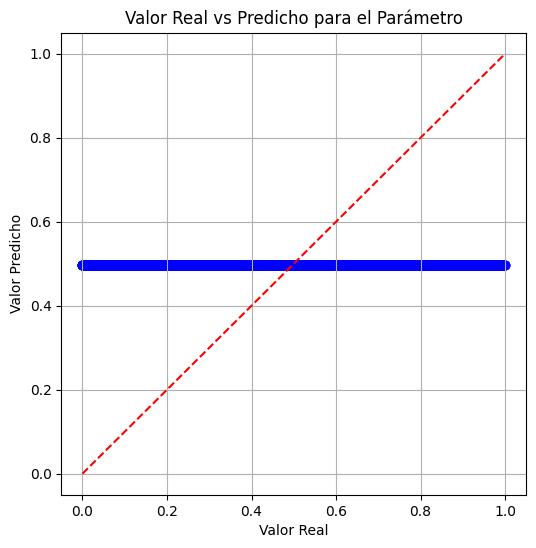

In [ ]:
# Realiza las predicciones usando el modelo
y_pred = final_model.predict(x_val)

# Las predicciones del modelo devuelven dos salidas: imagen y parámetros
# Necesitamos solo los parámetros predichos
y_pred_params = y_pred[1]

# Los valores reales también son los parámetros asociados
y_real_params = y_val_scaled

# Asumiendo que tenemos 4 parámetros, vamos a graficar un gráfico de dispersión para cada uno de ellos
num_params = y_real_params.shape[1]  # Esto debería ser 4 si tienes 4 parámetros

# Graficar para cada uno de los parámetros
plt.figure(figsize=(6, 6))
plt.scatter(y_real_params[:, 0], y_pred_params[:, 0], color='blue', alpha=0.5)
plt.plot([min(y_real_params[:, 0]), max(y_real_params[:, 0])],
         [min(y_real_params[:, 0]), max(y_real_params[:, 0])], color='red', linestyle='--')  # Línea de referencia
plt.title(f"Valor Real vs Predicho para el Parámetro")
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_real_params[:, 0], y_pred_params[:, 0])
mae =  mean_absolute_error(y_real_params[:, 0],y_pred_params[:, 0])
rmse =  mean_squared_error(y_real_params[:, 0],y_pred_params[:, 0])

print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.08464847142650597
mae:  0.25476896279627026
rmse:  0.08464847142650597


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_real_params[:, 0],y_pred_params[:, 0])
print(f"R²: {r2:.4f}")

R²: -0.0006


In [ ]:
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_real_params[:, 0], y_pred_params[:, 0])
print(f"MAPE: {mape:.2f}%")

MAPE: 283.08%


In [ ]:
import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Datos reales y predichos (ejemplo)
y_true = np.array([100, 200, 300, 0, 500])  # Incluye un 0 para probar SMAPE
y_pred = np.array([110, 190, 290, 10, 490])

# Calcular SMAPE
smape_value = smape(y_real_params[:, 0], y_pred_params[:, 0])
print(f"SMAPE: {smape_value:.2f}%")

SMAPE: 59.41%


In [ ]:
final_model.save_weights("modelo_unet_regresor_Jex3.weights.h5")